# 低阶API示范


In [2]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

## 线性回归模型

In [9]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [10]:
# 样本数量
n = 400
# 生成测试用数据集
X = 10 * torch.rand([n, 2],) - 5.0
w0 = torch.tensor([[2.0], [-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])

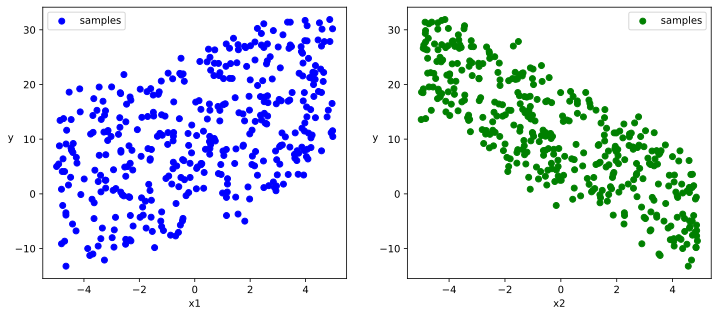

In [11]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c='b', label='samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c='g', label='samples')
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

In [13]:
# 构建数据管道迭代器

def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i : min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)

batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tensor([[ 1.0506,  2.0481],
        [ 1.2936, -2.7923],
        [-2.5271, -0.8721],
        [ 2.0685, -0.6364],
        [ 3.9740,  2.6404],
        [ 2.0799,  1.5846],
        [ 1.7558,  2.7964],
        [ 3.9838, -4.2639]])
tensor([[ 7.0122],
        [23.8198],
        [ 4.8970],
        [11.6519],
        [12.9686],
        [ 6.9027],
        [ 8.9095],
        [31.7170]])


In [14]:
class LinearRegression:
    def __init__(self):
        self.w = torch.randn_like(w0, requires_grad=True)
        self.b = torch.randn_like(b0, requires_grad=True)

    def forward(self, X):
        return X@self.w + self.b

    def loss_func(self, y_pred, y_true):
        return torch.mean((y_pred - y_true) ** 2 / 2)

model = LinearRegression()

In [15]:
def train_step(model, features, labels):
    pred = model.forward(features)
    loss = model.loss_func(pred, labels)
    loss.backward()

    with torch.no_grad():
        model.w -= 0.001 * model.w.grad
        model.b -= 0.001 * model.b.grad

        model.w.grad.zero_()
        model.b.grad.zero_()

    return loss

In [16]:
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

tensor(74.8053, grad_fn=<MeanBackward0>)

In [17]:
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)
        if epoch%200==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)

train_model(model, epochs=1000)


================================================================================2021-02-06 14:58:40
epoch = 200 loss =  3.215251922607422
model.w = tensor([[ 1.9707],
        [-2.9948]])
model.b = tensor([[9.9634]])

================================================================================2021-02-06 14:58:41
epoch = 400 loss =  2.4867141246795654
model.w = tensor([[ 1.9686],
        [-2.9965]])
model.b = tensor([[9.9667]])

================================================================================2021-02-06 14:58:43
epoch = 600 loss =  0.5694286823272705
model.w = tensor([[ 1.9693],
        [-2.9936]])
model.b = tensor([[9.9668]])

================================================================================2021-02-06 14:58:44
epoch = 800 loss =  1.0881664752960205
model.w = tensor([[ 1.9680],
        [-2.9979]])
model.b = tensor([[9.9665]])

================================================================================2021-02-06 14:58:45
epoch = 1000 loss =  3.47647

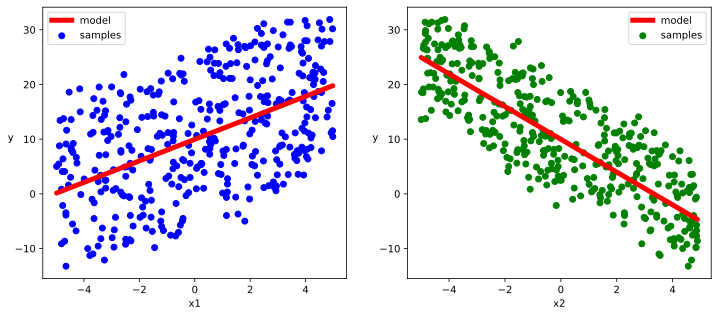

In [18]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(),Y[:, 0].numpy(), c="b", label="samples")
ax1.plot(X[:, 0].numpy(), (model.w[0].data * X[:, 0] + model.b[0].data).numpy(), "-r", linewidth=5.0, label="model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(),Y[:, 0].numpy(), c="g", label="samples")
ax2.plot(X[:, 1].numpy(), (model.w[1].data * X[:,1] + model.b[0].data).numpy(), "-r", linewidth=5.0, label="model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

## DNN二分类模型

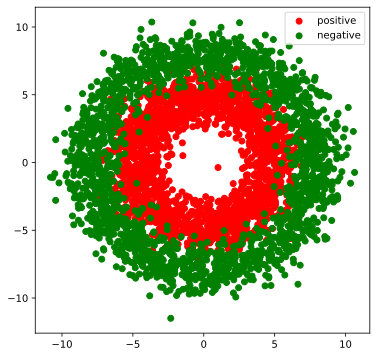

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

#正负样本数量
n_positive, n_negative = 2000, 2000

r_p = 5.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis=1)
Yp = torch.ones_like(r_p)

r_n = 8.0 + torch.normal(0.0, 1.0, size=[n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis=1)
Yn = torch.zeros_like(r_n)

X = torch.cat([Xp, Xn], axis=0)
Y = torch.cat([Yp, Yn], axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c='r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c='g')
plt.legend(['positive', 'negative'])

In [20]:
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i : min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)

batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tensor([[-4.3461,  6.7405],
        [ 7.7264,  1.1320],
        [-7.0606,  5.6050],
        [ 8.3578, -1.2531],
        [ 4.5504,  7.4002],
        [ 5.1178,  0.0960],
        [-5.4980,  7.3207],
        [-6.2340, -3.3524]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])


In [23]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2, 4))
        self.b1 = nn.Parameter(torch.zeros(1, 4))
        self.w2 = nn.Parameter(torch.randn(4, 8))
        self.b2 = nn.Parameter(torch.zeros(1, 8))
        self.w3 = nn.Parameter(torch.randn(8, 1))
        self.b3 = nn.Parameter(torch.zeros(1, 1))

    def forward(self, x):
        x = torch.relu(x@self.w1 + self.b1)
        x = torch.relu(x@self.w2 + self.b2)
        y = torch.sigmoid(x@self.w3 + self.b3)

        return y

    def loss_func(self, y_pred, y_true):
        eps = 1e-7
        y_pred = torch.clamp(y_pred, eps, 1 - eps)
        bce = - y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)
        return torch.mean(bce)

    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred > 0.5, torch.ones_like(y_pred, dtype=torch.float32), torch.zeros_like(y_pred, dtype=torch.float32))
        acc = torch.mean(1 - torch.abs(y_true - y_pred))

        return acc

model = DNNModel()

In [24]:
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))

predictions = model(features)

loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)

print("init loss:", loss.item())
print("init metric:", metric.item())

init loss: 3.9391777515411377
init metric: 0.7545157670974731


In [25]:
def train_step(model, features, labels):
    pred = model.forward(features)
    loss = model.loss_func(pred, labels)
    metric = model.metric_func(pred, labels)

    loss.backward()

    for param in model.parameters():
        param.data = (param.data - 0.01*param.grad.data)

    model.zero_grad()
    return loss.item(),metric.item()


def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_list, metric_list = [],[]
        for features, labels in data_iter(X, Y, 20):
            loss_cur, metric_cur = train_step(model, features, labels)
            loss_list.append(loss_cur)
            metric_list.append(metric_cur)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%100==0:
            printbar()
            print("epoch =", epoch, "loss = ", loss, "metric = ", metric)

train_model(model, epochs = 1000)


================================================================================2021-02-06 15:32:33
epoch = 100 loss =  0.19672099812887608 metric =  0.9237499931454658

================================================================================2021-02-06 15:32:44
epoch = 200 loss =  0.19189240879379213 metric =  0.9259999945759774

================================================================================2021-02-06 15:32:57
epoch = 300 loss =  0.18500324708409607 metric =  0.9267499920725822

================================================================================2021-02-06 15:33:11
epoch = 400 loss =  0.18366106417030095 metric =  0.9244999930262565

================================================================================2021-02-06 15:33:24
epoch = 500 loss =  0.17843778586480766 metric =  0.9294999921321869

================================================================================2021-02-06 15:33:37
epoch = 600 loss =  0.1782047054823488 metric =  

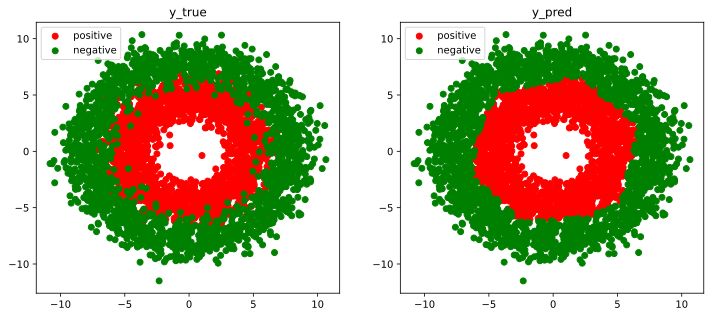

In [26]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
ax1.scatter(Xp[:,0], Xp[:,1], c="r")
ax1.scatter(Xn[:,0], Xn[:,1], c = "g")
ax1.legend(["positive", "negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X) >= 0.5)]
Xn_pred = X[torch.squeeze(model.forward(X) < 0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c = "r")
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c = "g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred");